## Mount Google drive locally

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Import necessary libraries

In [0]:
from os.path import isfile

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()
%matplotlib inline

## Load text database

In [0]:
data_excel = r'/content/drive/My Drive/Research/Data/Datos Ejercicio CIIURev4.xlsx'
assert isfile(data_excel), f'Data file not found in {data_excel}'

In [0]:
sheets_train = ['mes1', 'mes2', 'mes3']

df_train = pd.DataFrame()
for sheet in sheets_train:
  df_sheet = pd.read_excel(data_excel, sheet_name=sheet)
  df_train = df_train.append(df_sheet, ignore_index=True)

In [0]:
df_train.head()

,P6390,RAMA2D_R4
0,REALIZA INSTALACIONES ELECTRICAS EN LAS VIVIEN...,43
1,PESCA ARTESANAL A MAR ABIERTO,3
2,EDUCACION SUPERIOR,85
3,VENTA DE MEDICAMENTOS,47
4,CONSTRUCCION DE 0BRAS,41


Leer hoja de validación

In [0]:
df_test = pd.read_excel(data_excel, sheet_name='validacion')
df_test.head()

,consecutivo,P6390
0,1,CARGUE DESCARGUE Y ALMACENAMIENTO DE MERCANCIA...
1,2,MEDICINA VETERINARIA
2,3,ARREGLO Y DECORACION DE UÑAS
3,4,CARGUE DESCARGUE Y ALMACENAMIENTO DE MERCANCIA...
4,5,CUIDADO Y PROTECCION DE NIÑOS Y NIÑAS DE 0 A 5...


Data training shape: (90152, 2)
Number of classes: 88


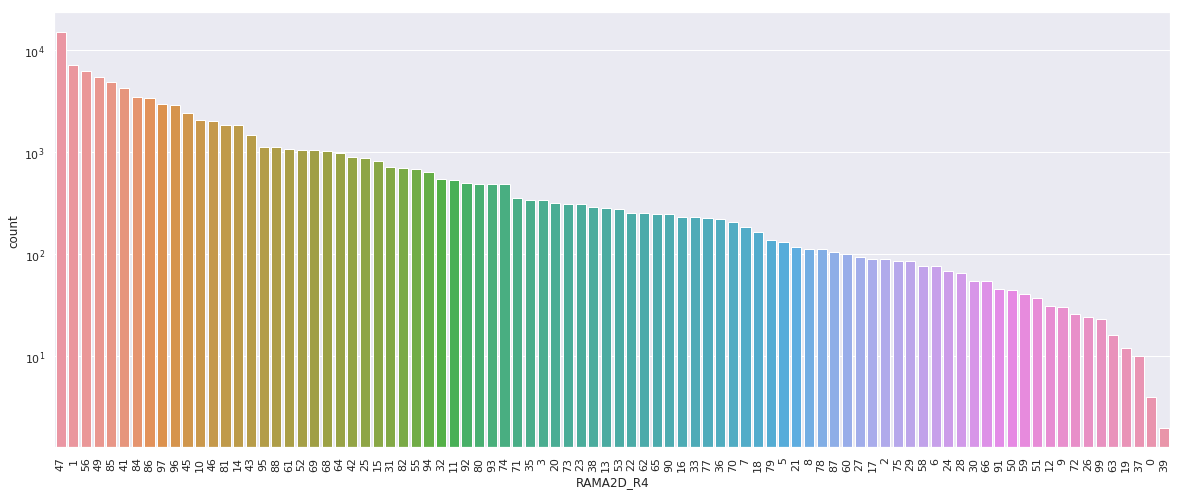

In [0]:
print(f'Data training shape: {df_train.shape}')
print(f'Number of classes: {len(df_train.RAMA2D_R4.value_counts())}')

plt.figure(figsize=(20,8))
sns.countplot(x='RAMA2D_R4', data=df_train, order=df_train['RAMA2D_R4'].value_counts().index)
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

## Clean dataset

In [0]:
df_train.query('RAMA2D_R4 == 0')

,P6390,RAMA2D_R4
9356,NO INFORMA,0
14189,CHSR,0
58825,VENDEDORA DE MOSTRADOR EN ALMACEN,0
80063,126,0


## Topic classification

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [0]:
X, y = df_train['P6390'], df_train['RAMA2D_R4']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21)

print(f'Training samples: {len(X_train)}')
print(f'Testing samples: {len(X_test)}')

Training samples: 67614
Testing samples: 22538


Feature extraction from the text

In [0]:
tfdif_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern='\w{1,}',
                             max_features=5000)

# Train the model
tfdif_vect.fit(X)

X_train_tfdif = tfdif_vect.transform(X_train)
X_test_tfdif = tfdif_vect.transform(X_test)

Create a model to classify the labels

In [0]:
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train_tfdif, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Compute metrics

Accuracy

In [0]:
y_pred = model.predict(X_test_tfdif)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.8713727926169137


Classification report

In [0]:
# target_names = y.astype('str').unique()
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.95      0.98      0.96      1783
           2       0.60      0.68      0.64        22
           3       0.95      0.98      0.96        84
           5       0.97      0.88      0.92        32
           6       0.79      0.79      0.79        19
           7       0.94      0.98      0.96        46
           8       0.70      0.75      0.72        28
           9       0.60      0.86      0.71         7
          10       0.70      0.68      0.69       517
          11       0.85      0.80      0.83       132
          12       1.00      0.38      0.55         8
          13       0.37      0.28      0.32        71
          14       0.85      0.93      0.89       455
          15       0.87      0.92      0.89       206
          16       0.73      0.67      0.70        57
          17       0.91      0.43      0.59        23
          18       0.50    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix

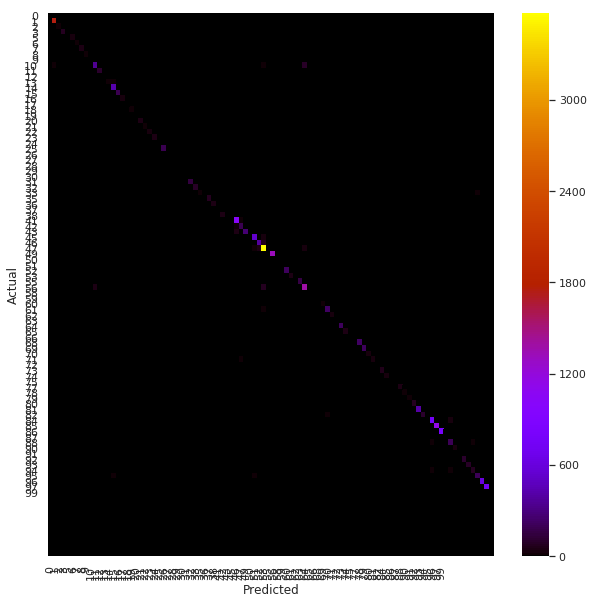

In [0]:
conf_mat = confusion_matrix(y_test_enc, y_pred)
categories = encoder.classes_

plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=False, 
            fmt='d', 
            cmap='gnuplot', 
            xticklabels=categories,
            yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Predict onto the validation data

In [0]:
from sklearn.pipeline import Pipeline

In [0]:
y_valid = df_test['P6390']

In [0]:
pipeline = Pipeline([
    ('vectorizer', tfdif_vect),
    ('clf', model)
])

In [0]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False, token_patt...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.

In [0]:
y_pred = pipeline.predict(X_valid)
y_pred = pd.Series(y_pred, name='RAMA2D_R4_PRED')

In [0]:
df_valid = pd.concat([X_valid, y_pred], axis='columns')
df_valid.sample(n=5)

,P6390,RAMA2D_R4_PRED
22095,TRANSPORTE INTERMUNICIPAL DE PASAJEROS EN TAXI,49
18631,SERVICIO DE LABORATORIO CLINICO,86
16605,SERVICIO DE TAPICERIA PARA VEHICULOS,45
22498,CULTIVO DE GUAYABA,1
27526,SERVICIO DE TRANSPORTE TERRESTRE DE PASAJEROS,49


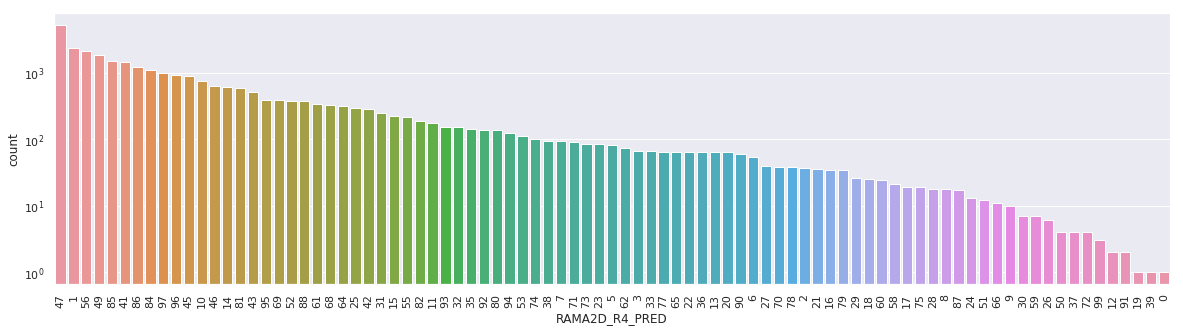

In [0]:
plt.figure(figsize=(20,5))
ordered_labels = df_valid['RAMA2D_R4_PRED'].value_counts().index
sns.countplot(x='RAMA2D_R4_PRED', data=df_valid, order=ordered_labels)
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [0]:
from time import sleep

for label in ordered_labels:
  print(df_valid.query(f'RAMA2D_R4_PRED == {label}').head())
  print('='*60)
  print(df_train.query(f'RAMA2D_R4 == {label}').head())
  print('\n\n')
  sleep(5)

                                        P6390  RAMA2D_R4_PRED
9   VENTA DE VIVERES Y ABARROTES AL POR MENOR              47
10                           LAVAR Y PLANCHAR              47
13                VENTA DE ALMUERZOS AL DETAL              47
14              VENTA DE GAS PROPANO AL DETAL              47
16              VENTA DE GAS PROPANO AL DETAL              47
                                                P6390  RAMA2D_R4
3                               VENTA DE MEDICAMENTOS         47
19                             VENDER FRUTAL AL DETAL         47
29              VENTA DE ROPA PARA DAMA POR CATALOGOS         47
33  COMERCIALIZACION DE ELECTRODOMESTICOS ROPA Y P...         47
36                     VENTA DE MEDICAMENTOS AL DETAL         47



                                                 P6390  RAMA2D_R4_PRED
63                               PRODUCCION DE PLATANO               1
100  SIEMBRA CULTIVO Y EXPORTACION DE FLORES EN GEN...               1
237  CULTIVO Y VENTA D